In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

unable to import 'smart_open.gcs', disabling that module


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Import Dataset
#df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
#print(df.target_names.unique())
#df.head()

df = pd.read_csv('./generated/leakgan.csv', quoting = 3).dropna().reset_index(drop=True)

In [4]:
df.columns

Index(['NARRATIVE'], dtype='object')

In [5]:
word_replace_dic = {
        ' vic ':' victim ',
        ' vict ':' victim ',
        ' sus ': ' suspect ',
        ' s1 ': ' suspect ',
        ' v1 ': ' victim ',
        ' loc ': ' location ',
        ' veh ':' vehicle ',
        ' prop ': ' property ',
        ' unk ': ' unknown ',
        ' v ' : ' victim ',
        ' s ': ' suspect ',
        ' ss ': ' suspect ',
        ' susp ': ' suspect ',
        ' remvd ': ' removed ',
        ' victs ': ' victims ',
        ' susps ': ' suspects ',
        ' stillinside ': ' still inside ',
        ' donttell ': ' dont tell ',
        ' veerbal ': ' verbal ',
        ' thransaction ': ' transaction ',
        ' usedcredit ': ' used credit ',
        ' beerbottle ' : ' beer bottle ',
        ' neg ': ' negative ',
        ' cointinuously ': ' continuously ',
        ' lemmon ': ' lemon ',
        ' att ': ' attack '
            }
df['content'] = " " + df['NARRATIVE'].str.lower()+ " "
#df['content'] = df.cleaned.replace(word_replace_dic)#, regex=True)

In [6]:

for key, value in word_replace_dic.items():
    df['content'] = df['content'].str.replace(key, value, 10)


In [7]:
df['NARRATIVE'][2673]

'unk susps entered victs guava tooth daghtr partners s gangs n bloodshot eyes.spunches v veh door enters n rmvs v prop '

In [8]:
df['content'][2673]

' unknown suspects entered victims guava tooth daghtr partners suspect gangs n bloodshot eyes.spunches victim vehicle door enters n rmvs victim property  '

In [9]:

for key, value in word_replace_dic.items():
    df['content'] = df['content'].str.replace(key, value, 10)

In [10]:
df[df['content'].str.contains(" vict ")]['content']
#df.columns #= ['DR', 'CRIMETYPE', 'BEGDATE', 'content', 'X', 'Y', 'NARRATIVE_FLAG']

Series([], Name: content, dtype: object)

In [11]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

[' suspect entered location and selected fightng pinned suspicion of violence with it suspects punched victim with a hammer and flees ']


### Tokenize words and Clean-up text

In [12]:

#I have set deacc=True to remove the punctuations.

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['suspect', 'entered', 'location', 'and', 'selected', 'fightng', 'pinned', 'suspicion', 'of', 'violence', 'with', 'it', 'suspects', 'punched', 'victim', 'with', 'hammer', 'and', 'flees']]


In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['suspect', 'entered', 'location', 'and', 'selected', 'fightng', 'pinned_suspicion', 'of', 'violence', 'with', 'it', 'suspects', 'punched', 'victim', 'with', 'hammer', 'and', 'flees']


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['entered', 'location', 'select', 'violence', 'suspect', 'punch', 'victim', 'hammer', 'flee']]


### Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [17]:
id2word[0]

'entered'

In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('entered', 1),
  ('flee', 1),
  ('hammer', 1),
  ('location', 1),
  ('punch', 1),
  ('select', 1),
  ('suspect', 1),
  ('victim', 1),
  ('violence', 1)]]

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.096*"register" + 0.094*"sex" + 0.065*"offender" + 0.058*"hand" + '
  '0.048*"kill" + 0.045*"go" + 0.038*"gang" + 0.031*"ask" + 0.028*"pull" + '
  '0.023*"im_goe"'),
 (1,
  '0.143*"open" + 0.086*"conceal" + 0.085*"pry" + 0.065*"strike" + '
  '0.063*"resid" + 0.055*"gain" + 0.052*"rear" + 0.047*"kick" + 0.037*"bomb" + '
  '0.020*"entrust"'),
 (2,
  '0.180*"smash" + 0.089*"unlock" + 0.047*"side" + 0.040*"fail" + 0.039*"dob" '
  '+ 0.032*"attach" + 0.029*"unrelated" + 0.029*"site" + 0.028*"busi" + '
  '0.025*"purse"'),
 (3,
  '0.080*"business" + 0.047*"door" + 0.046*"pay" + 0.040*"state" + '
  '0.039*"money" + 0.035*"premie" + 0.026*"entry" + 0.023*"push" + '
  '0.022*"approach" + 0.021*"unsecured"'),
 (4,
  '0.000*"schoenborn" + 0.000*"union" + 0.000*"medication" + '
  '0.000*"releasevict" + 0.000*"bday" + 0.000*"unkld" + 0.000*"dining" + '
  '0.000*"helmet" + 0.000*"regard" + 0.000*"agaisnt"'),
 (5,
  '0.099*"purchase" + 0.057*"call" + 0.051*"make" + 0.046*"attempt" + '
  '0.04

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.078750584011888

Coherence Score:  0.4753540724720604


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.439565  0.167692       1        1  57.482101
8     -0.125068 -0.425893       2        1   9.727759
3     -0.053495 -0.011300       3        1   7.977543
11    -0.036887 -0.007889       4        1   5.352995
2     -0.040514  0.055758       5        1   5.190061
1      0.013136  0.019662       6        1   4.076160
10     0.074456  0.037283       7        1   2.835521
9      0.069599  0.035497       8        1   2.721686
5      0.102662  0.041622       9        1   2.376482
0      0.105196  0.040607      10        1   2.186491
6      0.165240  0.023481      11        1   0.036634
4      0.165240  0.023481      12        1   0.036570, topic_info=     Category          Freq          Term         Total  loglift  logprob
6     Default  14919.000000       suspect  14919.000000  30.0000   30.000
7     Default  13788.000000        victim  13788.000000  29.0000   29.000
60    Default   2173.000000           use   2173.000000  28.0000   28.000
17    Default   9034.000000       unknown   9034.000000  27.0000   27.000
15    Default   1495.000000        remove   1495.000000  26.0000   26.000
85    Default   1369.000000          lose   1369.000000  25.0000   25.000
37    Default    972.000000         smash    972.000000  24.0000   24.000
56    Default    817.000000         carry    817.000000  23.0000   23.000
0     Default    726.000000       entered    726.000000  22.0000   22.000
71    Default    607.000000          open    607.000000  21.0000   21.000
1     Default   3406.000000          flee   3406.000000  20.0000   20.000
21    Default   3144.000000      property   3144.000000  19.0000   19.000
9     Default    664.000000      business    664.000000  18.0000   18.000
100   Default    463.000000         store    463.000000  17.0000   17.000
11    Default   2646.000000         enter   2646.000000  16.0000   16.000
32    Default    480.000000        unlock    480.000000  15.0000   15.000
200   Default    395.000000    approached    395.000000  14.0000   14.000
3     Default   2468.000000      location   2468.000000  13.0000   13.000
164   Default    455.000000        online    455.000000  12.0000   12.000
5     Default    365.000000        select    365.000000  11.0000   11.000
175   Default    365.000000       conceal    365.000000  10.0000   10.000
115   Default    359.000000           pry    359.000000   9.0000    9.000
74    Default    392.000000          door    392.000000   8.0000    8.000
50    Default    383.000000           pay    383.000000   7.0000    7.000
366   Default    407.000000          card    407.000000   6.0000    6.000
209   Default    245.000000      purchase    245.000000   5.0000    5.000
132   Default    274.000000        strike    274.000000   4.0000    4.000
96    Default   1572.000000       vehicle   1572.000000   3.0000    3.000
22    Default    267.000000         resid    267.000000   2.0000    2.000
412   Default    238.000000        motion    238.000000   1.0000    1.000
...       ...           ...           ...           ...      ...      ...
2622  Topic12      0.008303  movingoutsus      0.856633   3.2773   -8.429
2623  Topic12      0.008303     dashboard      0.856631   3.2773   -8.429
2625  Topic12      0.008303       slapped      0.856636   3.2773   -8.429
2573  Topic12      0.008303        visibl      0.856637   3.2773   -8.429
4577  Topic12      0.008303        fondle      0.881782   3.2484   -8.429
1528  Topic12      0.008303       worship      0.860780   3.2725   -8.429
1522  Topic12      0.008303      activate      0.857363   3.2765   -8.429
1523  Topic12      0.008303   removingthe      0.856625   3.2773   -8.429
1524  Topic12      0.008303          susp      0.856625   3.2773   -8.429
1525  Topic12      0.008303       suspunk      0.856625   3.2773   -8.429
1526  Topic12      0.008303        hostel      0.857060   3.2768   -8.429
1529  Topic12      

In [23]:

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

#mallet_path = 'F:\\mallet-2.0.8\\bin\\mallet'
mallet_path = "F:\\mallet-2.0.8\\bin\\mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

In [24]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=12, formatted=False))

[(0,
  [('unknown', 0.17231063778868014),
   ('vehicle', 0.16237884408280484),
   ('smash', 0.11236089505803518),
   ('window', 0.05396673447409357),
   ('liquie', 0.05360775397870049),
   ('door', 0.044872561924135454),
   ('rear', 0.030154361613019025),
   ('side', 0.02776115831039847),
   ('gain', 0.025607275338039966),
   ('entry', 0.022735431374895296)]),
 (1,
  [('victim', 0.19760130414531904),
   ('enter', 0.1313460642757336),
   ('pstone', 0.06963204471355379),
   ('unlock', 0.05193292966930601),
   ('secure', 0.04110386585933861),
   ('face', 0.030973451327433628),
   ('strike', 0.030624126688402423),
   ('punch', 0.029809035863996275),
   ('angry', 0.02503493246390312),
   ('push', 0.024452724732184444)]),
 (2,
  [('property', 0.26171165718436024),
   ('remove', 0.13981358189081225),
   ('unknown', 0.10737198886333374),
   ('enter', 0.0993826413267159),
   ('suspect', 0.08860912722430699),
   ('construction', 0.05931485292337489),
   ('site', 0.017673405156760684),
   ('flee'

In [25]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
# Compute Perplexity
#print('\nPerplexity: ', ldamallet.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Coherence Score:  0.4110654175704022


In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

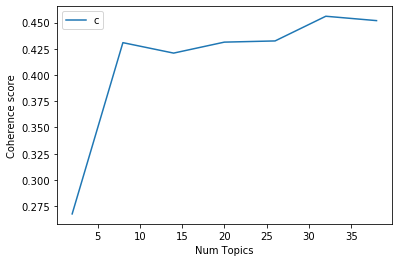

In [28]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2676
Num Topics = 8  has Coherence Value of 0.4308
Num Topics = 14  has Coherence Value of 0.4209
Num Topics = 20  has Coherence Value of 0.4313
Num Topics = 26  has Coherence Value of 0.4325
Num Topics = 32  has Coherence Value of 0.456
Num Topics = 38  has Coherence Value of 0.4518


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 12 topics itself.


In [30]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.343*"unknown" + 0.187*"flee" + 0.108*"direction" + 0.079*"location" + '
  '0.072*"suspect" + 0.053*"dir" + 0.026*"tool" + 0.023*"attach" + '
  '0.009*"busine" + 0.006*"sock"'),
 (1,
  '0.278*"suspect" + 0.191*"location" + 0.157*"flee" + 0.148*"victim" + '
  '0.063*"property" + 0.013*"punched" + 0.007*"apt" + 0.006*"portable" + '
  '0.006*"involved" + 0.006*"bedroom"'),
 (2,
  '0.206*"property" + 0.204*"unknown" + 0.144*"remove" + 0.098*"suspect" + '
  '0.069*"construction" + 0.050*"flee" + 0.021*"site" + 0.018*"break" + '
  '0.014*"unlocked" + 0.011*"flame"'),
 (3,
  '0.347*"victim" + 0.243*"suspect" + 0.060*"online" + 0.053*"approached" + '
  '0.034*"motion" + 0.009*"throw" + 0.008*"reach" + 0.007*"ssn" + '
  '0.007*"fight" + 0.006*"stop"'),
 (4,
  '0.104*"carry" + 0.100*"entered" + 0.078*"remove" + 0.076*"store" + '
  '0.059*"conceal" + 0.049*"pay" + 0.035*"item" + 0.031*"resid" + 0.025*"dob" '
  '+ 0.020*"suspect"'),
 (5,
  '0.320*"victim" + 0.125*"suspect" + 0.045*"leave"

In [31]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.198194 -0.245327       1        1  8.558613
3     -0.240313 -0.075333       2        1  8.469905
5      0.216328  0.176798       3        1  8.391960
7     -0.235868 -0.005591       4        1  8.387590
2      0.139520  0.080803       5        1  8.354927
8     -0.121042  0.141865       6        1  8.347752
0      0.347260 -0.160429       7        1  8.312619
6     -0.012100  0.196655       8        1  8.257141
9      0.137402  0.151649       9        1  8.252758
4     -0.029710  0.045460      10        1  8.230675
11    -0.219007 -0.009985      11        1  8.225561
10     0.215724 -0.296565      12        1  8.210499, topic_info=    Category          Freq          Term         Total  loglift  logprob
7    Default  13309.000000        victim  13309.000000  30.0000  30.0000
17   Default   8733.000000       unknown   8733.000000  29.0000  29.0000
21   Default   3156.000000      property   3156.000000  28.0000  28.0000
6    Default  14451.000000       suspect  14451.000000  27.0000  27.0000
1    Default   3334.000000          flee   3334.000000  26.0000  26.0000
85   Default   1501.000000          lose   1501.000000  25.0000  25.0000
11   Default   2494.000000         enter   2494.000000  24.0000  24.0000
3    Default   2450.000000      location   2450.000000  23.0000  23.0000
96   Default   1434.000000       vehicle   1434.000000  22.0000  22.0000
15   Default   1655.000000        remove   1655.000000  21.0000  21.0000
37   Default    973.000000         smash    973.000000  20.0000  20.0000
87   Default    905.000000     direction    905.000000  19.0000  19.0000
56   Default    788.000000         carry    788.000000  18.0000  18.0000
0    Default    747.000000       entered    747.000000  17.0000  17.0000
71   Default    626.000000          open    626.000000  16.0000  16.0000
29   Default    619.000000        pstone    619.000000  15.0000  15.0000
100  Default    567.000000         store    567.000000  14.0000  14.0000
9    Default    692.000000      business    692.000000  13.0000  13.0000
328  Default    515.000000  construction    515.000000  12.0000  12.0000
145  Default    466.000000        window    466.000000  11.0000  11.0000
261  Default    464.000000        liquie    464.000000  10.0000  10.0000
32   Default    461.000000        unlock    461.000000   9.0000   9.0000
175  Default    441.000000       conceal    441.000000   8.0000   8.0000
164  Default    437.000000        online    437.000000   7.0000   7.0000
366  Default    422.000000          card    422.000000   6.0000   6.0000
33   Default    414.000000           dir    414.000000   5.0000   5.0000
5    Default    410.000000        select    410.000000   4.0000   4.0000
86   Default    407.000000         steal    407.000000   3.0000   3.0000
115  Default    403.000000           pry    403.000000   2.0000   2.0000
74   Default    387.000000          door    387.000000   1.0000   1.0000
..       ...           ...           ...           ...      ...      ...
82   Topic12    214.469767          acct    214.469767   2.4998  -3.6837
110  Topic12    186.495450    permission    186.495450   2.4998  -3.8234
209  Topic12    246.588428      purchase    247.631788   2.4955  -3.5441
160  Topic12    146.088102        credit    146.088102   2.4998  -4.0676
221  Topic12    144.015931          cash    144.015931   2.4998  -4.0819
35   Topic12    137.799416          make    137.799416   2.4998  -4.1260
144  Topic12    137.799416        number    137.799416   2.4998  -4.1260
113  Topic12    113.969442          good    113.969442   2.4998  -4.3159
109  Topic12    111.897270        obtain    111.897270   2.4998  -4.3343
562  Topic12    106.716841       service    106.716841   2.4998  -4.3817
224  Topic12    102.572497         forge    102.572497   2.4998  -4.4213
83   Topic12    239.335827         check    241.422546   2.4911  -3.5740
518

In [32]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Perplexity:  nan


C:\Users\Samira\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1108: RuntimeWarning: invalid value encountered in multiply
  score += np.sum((self.eta - _lambda) * Elogbeta)
C:\Users\Samira\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1109: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(_lambda) - gammaln(self.eta))


## Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [33]:
def format_two_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                topic_num0 = topic_num
                prop_topic0 = prop_topic
                wp0 = ldamodel.show_topic(topic_num0)
                topic_keywords0 = ", ".join([word for word, prop in wp0])
            elif j == 1:  # => dominant topic
                topic_num1 = topic_num
                prop_topic1 = prop_topic
                wp1 = ldamodel.show_topic(topic_num1)
                topic_keywords1 = ", ".join([word for word, prop in wp1])
            else:
                break
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num0), round(prop_topic0,4), topic_keywords0,int(topic_num1), round(prop_topic1,4), topic_keywords1]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic0', 'Perc_Contribution0', 'Topic_Keywords0', 'Dominant_Topic1', 'Perc_Contribution1', 'Topic_Keywords1']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#df_two_topic_sents_keywords = format_two_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_two_topic_sents_keywords = format_two_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_two_dominant_topic = df_two_topic_sents_keywords.reset_index()
df_two_dominant_topic.columns = ['Document_No', 'Dominant_Topic0', 'Topic_Perc_Contrib0', 'Keywords0', 'Dominant_Topic1', 'Topic_Perc_Contrib1', 'Keywords1', 'Text']

# Show
df_two_dominant_topic.head(10)

,Document_No,Dominant_Topic0,Topic_Perc_Contrib0,Keywords0,Dominant_Topic1,Topic_Perc_Contrib1,Keywords1,Text
0,0,11.0,0.1158,"victim, suspect, enter, select, sex, register,...",6.0,0.0970,"suspect, entered, store, location, conceal, pa...",suspect entered location and selected fightng...
1,1,4.0,0.1153,"suspect, victim, unknown, carry, business, rem...",8.0,0.1003,"victim, suspect, flee, location, property, unk...",unknown suspect entered victims unsecured pre...
2,2,8.0,0.1241,"victim, suspect, flee, location, property, unk...",6.0,0.1033,"suspect, entered, store, location, conceal, pa...",suspect entered victim resid thru para tfmv f...
3,3,1.0,0.1345,"victim, enter, pstone, unlock, secure, face, s...",8.0,0.0958,"victim, suspect, flee, location, property, unk...",unknown suspect entered victims unlocked psto...
4,4,0.0,0.1083,"unknown, vehicle, smash, window, liquie, door,...",10.0,0.1046,"lose, unknown, card, steal, purchase, check, a...",unknown suspect smashed wind made sf basin sc...
5,5,11.0,0.1364,"victim, suspect, enter, select, sex, register,...",3.0,0.0818,"victim, suspect, leave, state, money, approach...",suspect and victim were playing freeway regis...
6,6,7.0,0.1157,"victim, suspect, online, approached, motion, i...",0.0,0.1009,"unknown, vehicle, smash, window, liquie, door,...",victim was walking westbound sidewall insuffi...
7,7,3.0,0.1020,"victim, suspect, leave, state, money, approach...",1.0,0.0939,"victim, enter, pstone, unlock, secure, face, s...",victim stated that unknown noodle vibration t...
8,8,2.0,0.1101,"property, remove, unknown, enter, suspect, con...",0.0,0.0942,"unknown, vehicle, smash, window, liquie, door,...",unknown suspect smashed victims busi 290 bomb...
9,9,3.0,0.1062,"victim, suspect, leave, state, money, approach...",9.0,0.0982,"suspect, unknown, open, flee, pry, security, p...",suspect called victims resid via usmails1 dem...


In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.1158,"victim, suspect, enter, select, sex, register,...",suspect entered location and selected fightng...
1,1,4.0,0.1153,"suspect, victim, unknown, carry, business, rem...",unknown suspect entered victims unsecured pre...
2,2,8.0,0.1241,"victim, suspect, flee, location, property, unk...",suspect entered victim resid thru para tfmv f...
3,3,1.0,0.1345,"victim, enter, pstone, unlock, secure, face, s...",unknown suspect entered victims unlocked psto...
4,4,0.0,0.1083,"unknown, vehicle, smash, window, liquie, door,...",unknown suspect smashed wind made sf basin sc...
5,5,11.0,0.1364,"victim, suspect, enter, select, sex, register,...",suspect and victim were playing freeway regis...
6,6,7.0,0.1157,"victim, suspect, online, approached, motion, i...",victim was walking westbound sidewall insuffi...
7,7,3.0,0.1020,"victim, suspect, leave, state, money, approach...",victim stated that unknown noodle vibration t...
8,8,2.0,0.1101,"property, remove, unknown, enter, suspect, con...",unknown suspect smashed victims busi 290 bomb...
9,9,3.0,0.1062,"victim, suspect, leave, state, money, approach...",suspect called victims resid via usmails1 dem...


## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. 

In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2970,"unknown, vehicle, smash, window, liquie, door,...",suspect entered location and selected fightng...
1,1.0,0.2457,"victim, enter, pstone, unlock, secure, face, s...",unknown suspect entered victims unlocked psto...
2,2.0,0.2196,"property, remove, unknown, enter, suspect, con...",unknown suspect broke lock construction const...
3,3.0,0.3119,"victim, suspect, leave, state, money, approach...",victim and suspect are friends who inv regist...
4,4.0,0.3726,"suspect, victim, unknown, carry, business, rem...",unknown suspect used unknown pocketbook mates...


In [36]:
sent_two_topics_sorteddf_mallet = pd.DataFrame()

sent_two_topics_outdf_grpd = df_two_topic_sents_keywords.groupby('Dominant_Topic0')

for i, grp in sent_two_topics_outdf_grpd:
    sent_two_topics_sorteddf_mallet = pd.concat([sent_two_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution0'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_two_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
#sent_two_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_two_topics_sorteddf_mallet.head()

,Dominant_Topic0,Perc_Contribution0,Topic_Keywords0,Dominant_Topic1,Perc_Contribution1,Topic_Keywords1,0
0,0.0,0.2970,"unknown, vehicle, smash, window, liquie, door,...",11.0,0.0793,"victim, suspect, enter, select, sex, register,...",suspect entered location and selected fightng...
1,1.0,0.2457,"victim, enter, pstone, unlock, secure, face, s...",3.0,0.0805,"victim, suspect, leave, state, money, approach...",unknown suspect entered victims unlocked psto...
2,2.0,0.2196,"property, remove, unknown, enter, suspect, con...",0.0,0.0842,"unknown, vehicle, smash, window, liquie, door,...",unknown suspect broke lock construction const...
3,3.0,0.3119,"victim, suspect, leave, state, money, approach...",11.0,0.0822,"victim, suspect, enter, select, sex, register,...",victim and suspect are friends who inv regist...
4,4.0,0.3726,"suspect, victim, unknown, carry, business, rem...",8.0,0.0600,"victim, suspect, flee, location, property, unk...",unknown suspect used unknown pocketbook mates...


## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [37]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,11.0,"victim, suspect, enter, select, sex, register,...",1309.0,0.1311
1,4.0,"suspect, victim, unknown, carry, business, rem...",1000.0,0.1002
2,8.0,"victim, suspect, flee, location, property, unk...",744.0,0.0745
3,1.0,"victim, enter, pstone, unlock, secure, face, s...",758.0,0.0759
4,0.0,"unknown, vehicle, smash, window, liquie, door,...",783.0,0.0784
5,11.0,"victim, suspect, enter, select, sex, register,...",638.0,0.0639
6,7.0,"victim, suspect, online, approached, motion, i...",921.0,0.0922
7,3.0,"victim, suspect, leave, state, money, approach...",694.0,0.0695
8,2.0,"property, remove, unknown, enter, suspect, con...",263.0,0.0263
9,3.0,"victim, suspect, leave, state, money, approach...",585.0,0.0586


In [38]:
# Show
df_dominant_topics.head(12)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,11.0,"victim, suspect, enter, select, sex, register,...",1309.0,0.1311
1,4.0,"suspect, victim, unknown, carry, business, rem...",1000.0,0.1002
2,8.0,"victim, suspect, flee, location, property, unk...",744.0,0.0745
3,1.0,"victim, enter, pstone, unlock, secure, face, s...",758.0,0.0759
4,0.0,"unknown, vehicle, smash, window, liquie, door,...",783.0,0.0784
5,11.0,"victim, suspect, enter, select, sex, register,...",638.0,0.0639
6,7.0,"victim, suspect, online, approached, motion, i...",921.0,0.0922
7,3.0,"victim, suspect, leave, state, money, approach...",694.0,0.0695
8,2.0,"property, remove, unknown, enter, suspect, con...",263.0,0.0263
9,3.0,"victim, suspect, leave, state, money, approach...",585.0,0.0586


In [ ]:
df_dominant_topic.to_csv('df_dominant_topics_leakgan.csv')